In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import difflib
import yfinance as yf
from sklearn.linear_model import LinearRegression
from beta_values import *

days_in_quarter = 63

We describe our strategy in four parts:

(1)  **When to invest?**

The idea of our strategy is to invest after a day during which the ETF volume is statistically large and the ETF volume is negative.  We compute these days in `high_volume_neg_return_days` below. The reason we focus on these days is that, on these days, the correlations among the stocks in the ETF is abnormally high.  These large selloffs are often a response to a large macro shock that affects many of the stocks within the ETF.  The idea of our strategy is based on the theory that, when these large ETF selloffs happen, some stocks in the ETF are "dragged down" along with the ETF even though, from a fundamental perspective, they should be less exposed to the macro shock that drove the selloff.

(2)  **Which stocks to invest in?**

We want to invest in stocks we label *outsider* stocks.  Roughly speaking, these are stocks within an ETF that respond less strongly to the movements of the ETF.  The intuition is that these outsider stocks are generally less likely to be affected by the macro developments that affect the ETF, and so these are the stocks whose prices are most likely to be distorted during large selloffs of the ETF.

How do we precisely measure this notion of *outsider* stock?  

To measure the stocks that respond less strongly to the movements of the ETF, we compute the coefficient $\beta$ of the exponentially weighted linear regression of the returns of the stock against the returns of the ETF.  (The reason we introduce this exponential weighting is that we want to weight more recent returns more heavily than less recent ones.  We used the same weighting approach in our calculation of the ETF volume spikes above.)  

This coefficient $\beta$ is called the *ETF beta* of the stock.  Note that the ETF beta changes from day to day, since we must update our regression model each day based on the new day's returns.  In `betas_each_day` (constructed in the notebook `beta_values.py`) we compile, for each ETF, a dataframe that contains these ETF betas for each stock and each day during the time period we are studying.

Once we have computed these ETF betas, we define the ETF's outsider stocks on a given day as the stocks whose ETF betas that day fall in the bottom 10 percent. In `outsider_stocks`, we assign a value of `True` to a stock on a given day if that stock is an outsider to its ETF on that day.

(3)  **How do we measure the performance of our choice of stock against the ETF?**

Once we choose a day $D$ and a stock $S$ within an ETF, we must determine the following: if we invested in the stock $S$ at the *close* of day $D$ and held it for 40 days, how does the stock's return $r_S$ compare with the return $r_{ETF}$ of the ETF over that same period?  Since we want to measure our portfolio's alpha compared with the ETF, we leverage our portfolio with the ETF beta value $\beta_S$ of the stock on day $D$.  Therefore, we define the alpha of the stock's 40-day return versus the ETF as $r_S/\beta_S - r_{ETF}$.  These alphas are computed in `stock_40_day_alpha`.

We emphasize that `stock_40_day_alpha` does not specify *which* stocks to invest in, or *when* to invest in these stocks.  It tells us that *if* we invest in this stock following this trading day, what is the associated alpha value: i.e., to what degree does this stock's leveraged 40-day return outperform that of the ETF.

(4)  **Putting it all together.**

Now that we have determined which stocks to invest in and when, and how to measure the performance of our investment choice, we can combine these steps to evaluate the performance of our overall strategy.  In `portfolio_alphas`, we multiply each pair of dataframes in `outsider_stocks` and `stock_40_day_alpha` to obtain the alphas associated to each of the investments dictated by our strategy.  In `portfolio_average_alphas`, we average over each of these dataframes to get, for each ETF, the average value of alpha for our investments in that ETF's stocks.

In [2]:
# List of ETFs we consider in this work.

etf_tickers = {
    'XLY',
    'XLP',
    'XLE',
    'XLF',
    'XLV',
    'XLI',
    'XLB',
    'XLK',
    'XLU',
    'XLRE',
    'XLC'
}

(1)  **When to invest?**  We calculate the days with statistically high ETF volume and negative ETF returns.  We store this information in `high_volume_neg_return_days`.

In [3]:
# This code retrieves the ETF beta values of the stocks in each ETF compiled in `beta_values.py`.
# Note that the ETF beta on a given day depends only on returns from previous days (not including that day).

betas_per_day = {}

for etf in etf_tickers:
    df = pd.read_csv(f"data/{etf}_betas_per_day.csv")
    df.set_index(df.columns[0],inplace=True)
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index)
    betas_per_day[etf] = df

In [4]:
# Function to calculate when the volume of a stock or ETF is "statistically large".

def exp_weighted_z_score(data,halflife):
    return (data - data.ewm(halflife=halflife).mean().shift(1)) / data.ewm(halflife=halflife).std().shift(1) 

def high_volume_negative_return(ticker, threshold=3, halflife=days_in_quarter):
  
    negative_returns = returns(ticker) < 0
    
    vol = yf.Ticker(ticker).history(period='max').Volume.tz_localize(None)    
    vol_z_scores = exp_weighted_z_score(vol,halflife=halflife)
    
    high_vol_neg_return = (vol_z_scores >= threshold) * negative_returns
    
    return high_vol_neg_return

high_volume_neg_return_days = {}

for etf in etf_tickers:
    high_volume_neg_return_days[etf] = high_volume_negative_return(etf)

(2)  **Which stocks to invest in?**  We calculate each day's "outsider stocks" in each ETF.  (Note that the outsider stocks for a given day is determined by information from *before* that day.)  We store this information in `outsider_stocks`.

In [5]:
# We define the outsider stocks in an ETF on a given day as those whose ETF betas that day 
# are in the bottom 10 percent.

outsider_stocks = {}

def is_in_lower_quantile(row,level=0.1):
    threshold = row.quantile(level)
    return row <= threshold

for etf in etf_tickers:
    outsider_stocks[etf] = betas_per_day[etf].apply(is_in_lower_quantile, axis=1)

In [6]:
outsider_stocks['XLF']['AIZ'].any()

True

In [7]:
outsider_stocks['XLF']

,ACGL,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,ARCC,...,STT,SYF,TFC,TRV,UNM,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-28,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-29,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


(3)  **How do we measure the performance of our choice of stock against the ETF?**  

We compute the alpha from investing in a stock at the close of the given day nad holding for 40 days, leveraged against the ETF, compared to investing in the ETF for those 40 days.  We store the results in `stock_40_day_alpha`.

In [8]:
holding_period = 40 

# One can test other values to see what happens when you instead hold the stock for a different 
# number of days.  We are using the time horizon of 40 days based on the testing in Lynch et al.'s work.
# In future analysis, it would be interesting to explore varying this value based on developments 
# in the sector and in the overall market. 

In [9]:
# Initialize dictionaries to store various computed metrics
stock_log_returns = {}
stock_40_day_returns = {}
stock_40_day_alpha = {}
stock_40_day_volatility = {}  # New dictionary to store 40-day volatility

# Iterate over each ETF ticker
for num, etf in enumerate(etf_tickers):     
    print(f'{num + 1}. Prying into ETF: {etf}')
    
    # Compile tickers of both the ETF and all stocks in the ETF's holdings from the time period being considered
    tickers = [etf]
    stocks = holdings_per_day[etf].columns
    tickers.extend(stocks.values.tolist())

    # Define the time period for analysis
    start_date = holdings_per_day[etf].index[0]
    end_date = holdings_per_day[etf].index[-1]
    
    # Compute the log returns for each ticker over the specified period
    etf_stock_log_returns = pd.DataFrame({ticker: log_returns(ticker, start_date=start_date, end_date=end_date) for ticker in tickers})
    
    # Compute 40-day returns by compounding daily log returns
    etf_stock_40_day_returns = np.exp(sum(etf_stock_log_returns.shift(-i) for i in range(1, 1 + holding_period))) - 1
    
    # Compute the alpha by adjusting stock returns with ETF returns and stock betas
    df = etf_stock_40_day_returns[stocks].copy()
    total_stocks = len(stocks)

    for i, stock in enumerate(stocks, start=1):
        # Adjust stock returns by the ETF beta and subtract ETF returns
        df[stock] = (df[stock] - etf_stock_40_day_returns[etf]) / betas_per_day[etf][stock]
        
    print(f'Done with computing return difference for all {total_stocks} stocks in the ETF: {etf}')
        
    # Drop rows where all elements are NaN
    df = df.dropna(how='all')
    
    # Store the computed alpha values
    etf_stock_40_day_alpha = df

    # Compute the 40-day rolling volatility for each stock
    etf_stock_40_day_volatility = etf_stock_40_day_returns.rolling(window=holding_period).std()
    
    # Store all computed information in respective dictionaries
    stock_log_returns[etf] = etf_stock_log_returns
    stock_40_day_returns[etf] = etf_stock_40_day_returns
    stock_40_day_alpha[etf] = etf_stock_40_day_alpha
    stock_40_day_volatility[etf] = etf_stock_40_day_volatility  # Store the 40-day volatility

print(f'Done with all {num + 1} ETFs')

1. Prying into ETF: XLP
Done with computing return difference for all 41 stocks in the ETF: XLP
2. Prying into ETF: XLY
Done with computing return difference for all 73 stocks in the ETF: XLY
3. Prying into ETF: XLF
Done with computing return difference for all 81 stocks in the ETF: XLF
4. Prying into ETF: XLRE
Done with computing return difference for all 39 stocks in the ETF: XLRE
5. Prying into ETF: XLI
Done with computing return difference for all 93 stocks in the ETF: XLI
6. Prying into ETF: XLK
Done with computing return difference for all 91 stocks in the ETF: XLK
7. Prying into ETF: XLC
Done with computing return difference for all 29 stocks in the ETF: XLC
8. Prying into ETF: XLV
Done with computing return difference for all 76 stocks in the ETF: XLV
9. Prying into ETF: XLE
Done with computing return difference for all 32 stocks in the ETF: XLE
10. Prying into ETF: XLU
Done with computing return difference for all 32 stocks in the ETF: XLU
11. Prying into ETF: XLB
Done with co

In [61]:
stock_40_day_returns['XLF']

,XLF,ACGL,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,...,STT,SYF,TFC,TRV,UNM,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,0.097410,0.015689,0.067192,-0.022071,0.083830,0.052194,0.050854,0.079021,0.151498,0.073637,...,0.306313,0.134963,0.048471,-0.060941,0.079113,0.049147,0.107317,-0.013994,0.036663,0.163489
2019-10-02,0.124767,0.033782,0.089235,-0.010847,0.097581,0.080737,0.065425,0.131811,0.215067,0.100714,...,0.355100,0.169225,0.084218,-0.038977,0.148252,0.087433,0.131835,-0.009842,0.065903,0.192804
2019-10-03,0.118323,0.020671,0.076858,-0.010336,0.079271,0.070715,0.058652,0.134144,0.220169,0.089891,...,0.346361,0.167260,0.085797,-0.035349,0.166771,0.069121,0.134101,-0.030292,0.061895,0.173951
2019-10-04,0.091042,-0.008122,0.016177,-0.050891,0.043775,0.036059,0.029279,0.095955,0.201350,0.052379,...,0.325479,0.144989,0.061882,-0.066915,0.129731,0.034745,0.100044,-0.044141,0.034826,0.153566
2019-10-07,0.081259,-0.024261,0.000733,-0.045870,0.029953,0.031504,0.022967,0.096904,0.195095,0.052581,...,0.307925,0.142827,0.039670,-0.059588,0.071080,0.041765,0.087548,-0.045600,0.026281,0.125639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
stock_40_day_volatility['XLF'][39:61]

,XLF,ACGL,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,...,STT,SYF,TFC,TRV,UNM,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-25,0.028525,0.038762,0.029372,0.019269,0.025882,0.012356,0.018186,0.073142,0.066479,0.016196,...,0.093652,0.083681,0.022016,0.044296,0.059739,0.034471,0.078914,0.023730,0.024708,0.069175
2019-11-26,0.030269,0.038743,0.028685,0.019279,0.027290,0.012478,0.018177,0.075830,0.069142,0.016932,...,0.097283,0.087268,0.023014,0.043035,0.062699,0.034662,0.081578,0.024005,0.023979,0.071300
2019-11-27,0.030295,0.038852,0.025542,0.018824,0.026707,0.011819,0.017879,0.077756,0.070055,0.016461,...,0.098637,0.088514,0.023240,0.042460,0.062865,0.034857,0.083142,0.024736,0.024028,0.071519
2019-11-29,0.030354,0.038785,0.022732,0.018301,0.026451,0.011649,0.017981,0.078831,0.070290,0.016265,...,0.099639,0.089137,0.024072,0.042092,0.061049,0.035332,0.084241,0.025951,0.023984,0.072396
2019-12-02,0.030490,0.038300,0.022532,0.019110,0.026621,0.012590,0.018607,0.079510,0.069742,0.016191,...,0.100187,0.089280,0.027191,0.040230,0.060024,0.036456,0.084981,0.027594,0.023419,0.072996
2019-12-03,0.030976,0.037417,0.022504,0.019465,0.026638,0.016375,0.019162,0.079692,0.069557,0.016573,...,0.100899,0.089459,0.029329,0.038803,0.060204,0.036087,0.085768,0.028026,0.022162,0.074387
2019-12-04,0.030374,0.037535,0.021648,0.020574,0.026266,0.019969,0.019891,0.078111,0.065982,0.017607,...,0.099582,0.086856,0.030318,0.038002,0.058857,0.036143,0.085313,0.029758,0.022325,0.073733
2019-12-05,0.029659,0.037383,0.020787,0.021184,0.025938,0.022547,0.021068,0.075805,0.062459,0.018600,...,0.097082,0.084712,0.030784,0.036746,0.057729,0.036114,0.084650,0.030676,0.022706,0.072390
2019-12-06,0.028427,0.037790,0.020273,0.022738,0.025626,0.024301,0.023947,0.072416,0.058407,0.019228,...,0.093529,0.081530,0.030703,0.035585,0.056876,0.035890,0.083042,0.032137,0.022794,0.070604


In [70]:
# Create a column with False values
xlf_column = pd.Series([False] * len(outsider_stocks['XLF']), index=outsider_stocks['XLF'].index, name='XLF')
# Insert the False column at the beginning of the DataFrame
outsider_stocks['XLF'].insert(0, 'XLF', xlf_column)

In [71]:
outsider_stocks['XLF']

,XLF,ACGL,AFL,AIG,AIZ,AJG,ALL,AMG,AMP,AON,...,STT,SYF,TFC,TRV,UNM,V,WFC,WRB,WTW,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-10-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,False,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-28,False,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-29,False,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [154]:
outsider_stocks['XLF']['BRK-B'].any()

False

In [72]:
outsider_vol = stock_40_day_volatility['XLF'].loc[:,outsider_stocks['XLF'].any()].dropna()

In [73]:
outsider_vol

,ACGL,AIZ,AJG,AON,ARCC,BWMG,CBOE,CME,DIGAF,EG,...,MMC,MSCI,NDAQ,PGR,PLBC,SLF,SPGI,TRV,WRB,WTW
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-25,0.038762,0.025882,0.012356,0.016196,0.008302,0.124971,0.029196,0.033686,0.282908,0.028451,...,0.028353,0.049652,0.018497,0.052293,0.081184,0.019479,0.022005,0.044296,0.023730,0.024708
2019-11-26,0.038743,0.027290,0.012478,0.016932,0.007857,0.131764,0.029073,0.034335,0.284608,0.029578,...,0.029550,0.049689,0.018647,0.051590,0.088555,0.019802,0.022004,0.043035,0.024005,0.023979
2019-11-27,0.038852,0.026707,0.011819,0.016461,0.007741,0.134572,0.028448,0.035767,0.298501,0.030723,...,0.029298,0.048163,0.018321,0.051341,0.092649,0.019676,0.021853,0.042460,0.024736,0.024028
2019-11-29,0.038785,0.026451,0.011649,0.016265,0.007730,0.139003,0.028406,0.036620,0.305687,0.031654,...,0.029016,0.047174,0.019242,0.053024,0.096096,0.018979,0.022151,0.042092,0.025951,0.023984
2019-12-02,0.038300,0.026621,0.012590,0.016191,0.007823,0.146363,0.028464,0.037316,0.316923,0.031630,...,0.029148,0.046788,0.020518,0.054614,0.098671,0.018916,0.022822,0.040230,0.027594,0.023419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,0.068963,0.032633,0.061224,0.069636,0.018370,0.291358,0.045593,0.046890,0.000000,0.045586,...,0.039360,0.055068,0.030423,0.043916,0.091188,0.027144,0.046693,0.040146,0.036807,0.046777
2024-01-26,0.063526,0.032581,0.059236,0.068846,0.016954,0.290563,0.047212,0.046109,0.000000,0.044466,...,0.038191,0.055512,0.030135,0.042691,0.082663,0.026687,0.046074,0.041230,0.039207,0.045274
2024-01-29,0.058733,0.032692,0.056718,0.068048,0.015342,0.289387,0.048381,0.045114,0.000000,0.043261,...,0.036762,0.055979,0.030779,0.040954,0.072706,0.026468,0.045145,0.042190,0.041237,0.043164


In [77]:
outsider_vol_means = outsider_vol.where(outsider_stocks['XLF']).dropna(how='all').mean().to_dict()

In [83]:
# Calculate the annualized volatility using the mean of the rolling standard deviations
quarterly_volatility_outsider = {ticker: round(value * np.sqrt(63) * 100, 2) for ticker, value in outsider_vol_means.items()}


In [124]:
sorted(quarterly_volatility_outsider.items(), key=lambda x: x[1], reverse=True)

[('DIGAF', 374.11),
 ('BWMG', 174.64),
 ('PLBC', 75.13),
 ('ACGL', 69.1),
 ('WTW', 63.92),
 ('MKTX', 56.52),
 ('ARCC', 56.0),
 ('FDS', 50.48),
 ('MSCI', 48.99),
 ('AON', 43.9),
 ('ICE', 41.8),
 ('TRV', 40.38),
 ('PGR', 37.63),
 ('CBOE', 37.6),
 ('EG', 37.12),
 ('AIZ', 36.2),
 ('SPGI', 35.47),
 ('CME', 34.82),
 ('WRB', 34.7),
 ('MCO', 33.53),
 ('AJG', 28.83),
 ('SLF', 26.8),
 ('MMC', 24.92),
 ('NDAQ', 24.67)]

In [89]:
round(stock_40_day_volatility['XLF']['XLF'].mean()*np.sqrt(63)*100,2)

40.27

In [116]:
stock_40_day_returns['XLF']['XLF'][:-40]

Date
2019-10-01    0.097410
2019-10-02    0.124767
2019-10-03    0.118323
2019-10-04    0.091042
2019-10-07    0.081259
                ...   
2024-01-25    0.079614
2024-01-26    0.071548
2024-01-29    0.072410
2024-01-30    0.071552
2024-01-31    0.090779
Name: XLF, Length: 1091, dtype: float64

In [97]:
from statsmodels.graphics.tsaplots import plot_acf

In [13]:
# Plot the autocorrelation function (ACF) plot
plot_acf(stock_40_day_returns['XLF']['XLF'][:-40], lags=100)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(('ACF plot'), size = 20)
plt.show()

NameError: name 'plot_acf' is not defined

In [125]:
# Create a column with False values
xlv_column = pd.Series([False] * len(outsider_stocks['XLV']), index=outsider_stocks['XLV'].index, name='XLV')
# Insert the False column at the beginning of the DataFrame
outsider_stocks['XLV'].insert(0, 'XLV', xlv_column)

In [127]:
outsider_stocks['XLV']

,XLV,A,ABBV,ABT,ALGN,ALLE,AMGN,BAX,BDX,BIIB,...,UNH,VRTX,VTRS,WAT,WHSI,WST,XRAY,YNDX,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2019-10-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2019-10-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2019-10-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2019-10-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-28,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-03-29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [128]:
outsider_vol_XLV = stock_40_day_volatility['XLV'].loc[:,outsider_stocks['XLV'].any()].dropna()

In [129]:
outsider_vol_XLV

,ABBV,ALLE,AMGN,BAX,BDX,BMY,BSX,CAH,CIEN,COO,...,TRP,UHS,UNH,VRTX,VTRS,WAT,WHSI,XRAY,YNDX,ZBH
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-13,0.063736,0.098436,0.063439,0.072579,0.037547,0.025324,0.020727,0.035403,0.033363,0.043842,...,0.068502,0.101150,0.048605,0.039917,0.104320,0.028942,0.285224,0.068048,0.0,0.019494
2023-02-14,0.063583,0.096676,0.066053,0.080111,0.040715,0.025771,0.022082,0.036308,0.034883,0.046289,...,0.068158,0.094899,0.050800,0.043039,0.101265,0.026407,0.255101,0.066126,0.0,0.021150
2023-02-15,0.063506,0.092629,0.068267,0.086313,0.043295,0.026264,0.023718,0.037512,0.035812,0.045990,...,0.066853,0.089643,0.051708,0.046165,0.096893,0.023060,0.230566,0.063564,0.0,0.022577
2023-02-16,0.062971,0.088825,0.070748,0.091646,0.046208,0.027345,0.025939,0.038327,0.036414,0.045784,...,0.064761,0.082165,0.052146,0.049423,0.092476,0.021807,0.202126,0.062646,0.0,0.025186
2023-02-17,0.062257,0.084391,0.071965,0.094919,0.047760,0.027687,0.027519,0.038807,0.036260,0.046356,...,0.062526,0.073822,0.052341,0.051569,0.086333,0.020254,0.181553,0.061763,0.0,0.027411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-25,0.036866,0.066489,0.105934,0.019396,0.020273,0.033535,0.034252,0.043048,0.125133,0.041546,...,0.026085,0.041923,0.038204,0.104283,0.100013,0.064850,0.205511,0.064279,0.0,0.021846
2024-01-26,0.036307,0.064832,0.103629,0.019393,0.020473,0.034087,0.034639,0.042485,0.129318,0.040929,...,0.024765,0.041550,0.038293,0.101186,0.099441,0.064173,0.200918,0.060737,0.0,0.021367
2024-01-29,0.035610,0.062528,0.100792,0.019461,0.020571,0.034570,0.034567,0.042199,0.134582,0.039166,...,0.022429,0.041222,0.038606,0.097550,0.099003,0.063419,0.195347,0.055562,0.0,0.020781


In [148]:
outsider_vol_XLV_means = outsider_vol_XLV.where(outsider_stocks['XLV']).mean().dropna(how='all').to_dict()

In [149]:
outsider_vol_XLV_means

{'ABBV': 0.05940858216611298,
 'AMGN': 0.05628191996202963,
 'BMY': 0.028080708157085032,
 'BSX': 0.03432256495947902,
 'CAH': 0.05471844283147639,
 'COR': 0.040106019766090815,
 'DGX': 0.04759981026232053,
 'DVA': 0.09066835632671134,
 'DXCM': 0.1846309210308091,
 'GEHC': 0.05803323070198696,
 'HSIC': 0.07003801588265728,
 'HUM': 0.07029658614519858,
 'INCY': 0.04997142553566799,
 'JNJ': 0.04321504578333673,
 'LH': 0.03389330164043951,
 'MCK': 0.041870732248922175,
 'MRK': 0.041674987157638295,
 'MRNA': 0.12727945591219256,
 'PFE': 0.038536806651620736,
 'STT': 0.047869505887541845,
 'UNH': 0.03317973770270094,
 'XRAY': 0.1217666690136641,
 'ZBH': 0.03673502801695106}

In [150]:
# Calculate the annualized volatility using the mean of the rolling standard deviations
quarterly_volatility_outsider_XLV = {ticker: round(value * np.sqrt(63) * 100, 2) for ticker, value in outsider_vol_XLV_means.items()}


In [151]:
sorted(quarterly_volatility_outsider_XLV.items(), key=lambda x: x[1], reverse=True)

[('DXCM', 146.55),
 ('MRNA', 101.02),
 ('XRAY', 96.65),
 ('DVA', 71.97),
 ('HUM', 55.8),
 ('HSIC', 55.59),
 ('ABBV', 47.15),
 ('GEHC', 46.06),
 ('AMGN', 44.67),
 ('CAH', 43.43),
 ('INCY', 39.66),
 ('STT', 38.0),
 ('DGX', 37.78),
 ('JNJ', 34.3),
 ('MCK', 33.23),
 ('MRK', 33.08),
 ('COR', 31.83),
 ('PFE', 30.59),
 ('ZBH', 29.16),
 ('BSX', 27.24),
 ('LH', 26.9),
 ('UNH', 26.34),
 ('BMY', 22.29)]

In [152]:
round(stock_40_day_volatility['XLV']['XLV'].mean()*np.sqrt(63)*100,2)

30.49

In [ ]:
stock_40_day_returns['XLF']['XLF'][:-40]

Date
2019-10-01    0.097410
2019-10-02    0.124767
2019-10-03    0.118323
2019-10-04    0.091042
2019-10-07    0.081259
                ...   
2024-01-25    0.079614
2024-01-26    0.071548
2024-01-29    0.072410
2024-01-30    0.071552
2024-01-31    0.090779
Name: XLF, Length: 1091, dtype: float64

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

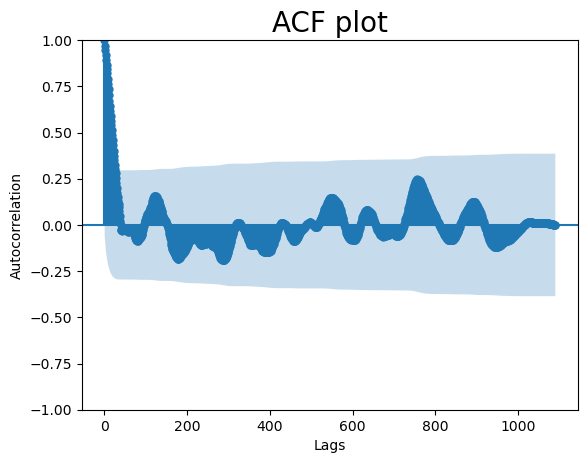

In [ ]:
# Plot the autocorrelation function (ACF) plot
plot_acf(stock_40_day_returns['XLF']['XLF'][:-40], lags=1090)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title(('ACF plot'), size = 20)
plt.show()

(4)  **Putting it all together.**  

In [10]:
alphas = {}
alphas_mean = {}

for etf in etf_tickers:
    
    index = stock_40_day_alpha[etf].index 
    
    outsiders = outsider_stocks[etf].shift(-1).reindex(index)
    high_vol_neg_return = high_volume_neg_return_days[etf].reindex(index)
    
    outsiders = outsiders.mul(high_vol_neg_return, axis=0).replace(False, np.nan)
    
    alphas[etf] = outsiders * stock_40_day_alpha[etf]
    
    alphas[etf] = alphas[etf].dropna(how='all')
    
    alphas_mean[etf] = alphas[etf].mean(axis=1).mean()

/tmp/ipykernel_30071/1460598394.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outsiders = outsiders.mul(high_vol_neg_return, axis=0).replace(False, np.nan)
/tmp/ipykernel_30071/1460598394.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  outsiders = outsiders.mul(high_vol_neg_return, axis=0).replace(False, np.nan)
/tmp/ipykernel_30071/1460598394.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(c

### Graph Rough Drafts

In [11]:
alphas_mean

{'XLP': -0.06038105619241035,
 'XLY': -0.032659673807934504,
 'XLF': 0.5099820705347639,
 'XLRE': -0.03441930749654924,
 'XLI': 0.19738794269231075,
 'XLK': -0.042898609482950434,
 'XLC': -0.9544276776532757,
 'XLV': 2.090981650958624,
 'XLE': -0.13581936109394055,
 'XLU': -0.29349383730270046,
 'XLB': -1.9379204484050967}

NameError: name 'bars' is not defined

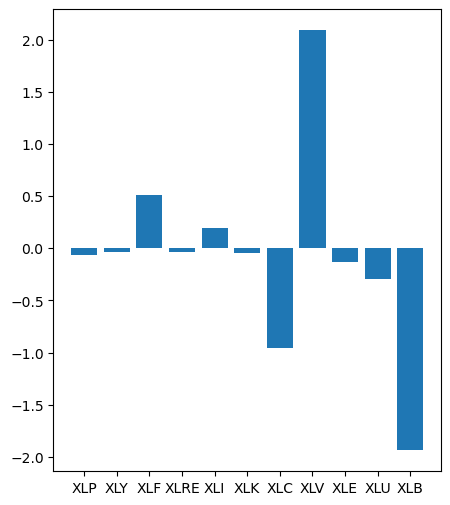

In [12]:
import matplotlib.pyplot as plt

# Define the dictionary
data = {'XLY': -0.04188163485551863,
        'XLRE': -0.10188650561674585,
        'XLU': -0.8645125299871198,
        'XLF': 0.2519229650162758,
        'XLI': 0.05931336636956355,
        'XLP': -0.04617517348973918,
        'XLB': -1.531289540823735,
        'XLE': -0.20634553470982842,
        'XLC': -0.25340731594607,
        'XLV': 1.6925345865023784,
        'XLK': 0.004161965443638465}

# Extract keys (stock symbols) and values (performance) from the dictionary
stocks = list(alphas_mean.keys())
performance = list(alphas_mean.values())

# Create a bar chart
plt.figure(figsize=(5, 6))  # Adjust figure size as needed 
plt.bar(stocks, performance)

# Add data labels above each bar
for bar, value in zip(bars, performance):
  yval = bar.get_height()  # Get the height of each bar
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{value:.2f}", ha='center', va='bottom')  # Adjust offset as needed


# Set chart labels and title
plt.xlabel("ETF Symbol")
plt.ylabel("Performance (Alpha)")
plt.title("Strategy vs Given ETF ('19-'24)")

# Rotate x-axis labels for better readability with many tick labels
plt.xticks(rotation=45)

# Show the chart
plt.tight_layout()
plt.show()

/var/folders/bg/mkf8kd597wg9rdyn5s8t1m980000gs/T/ipykernel_80381/2767995731.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


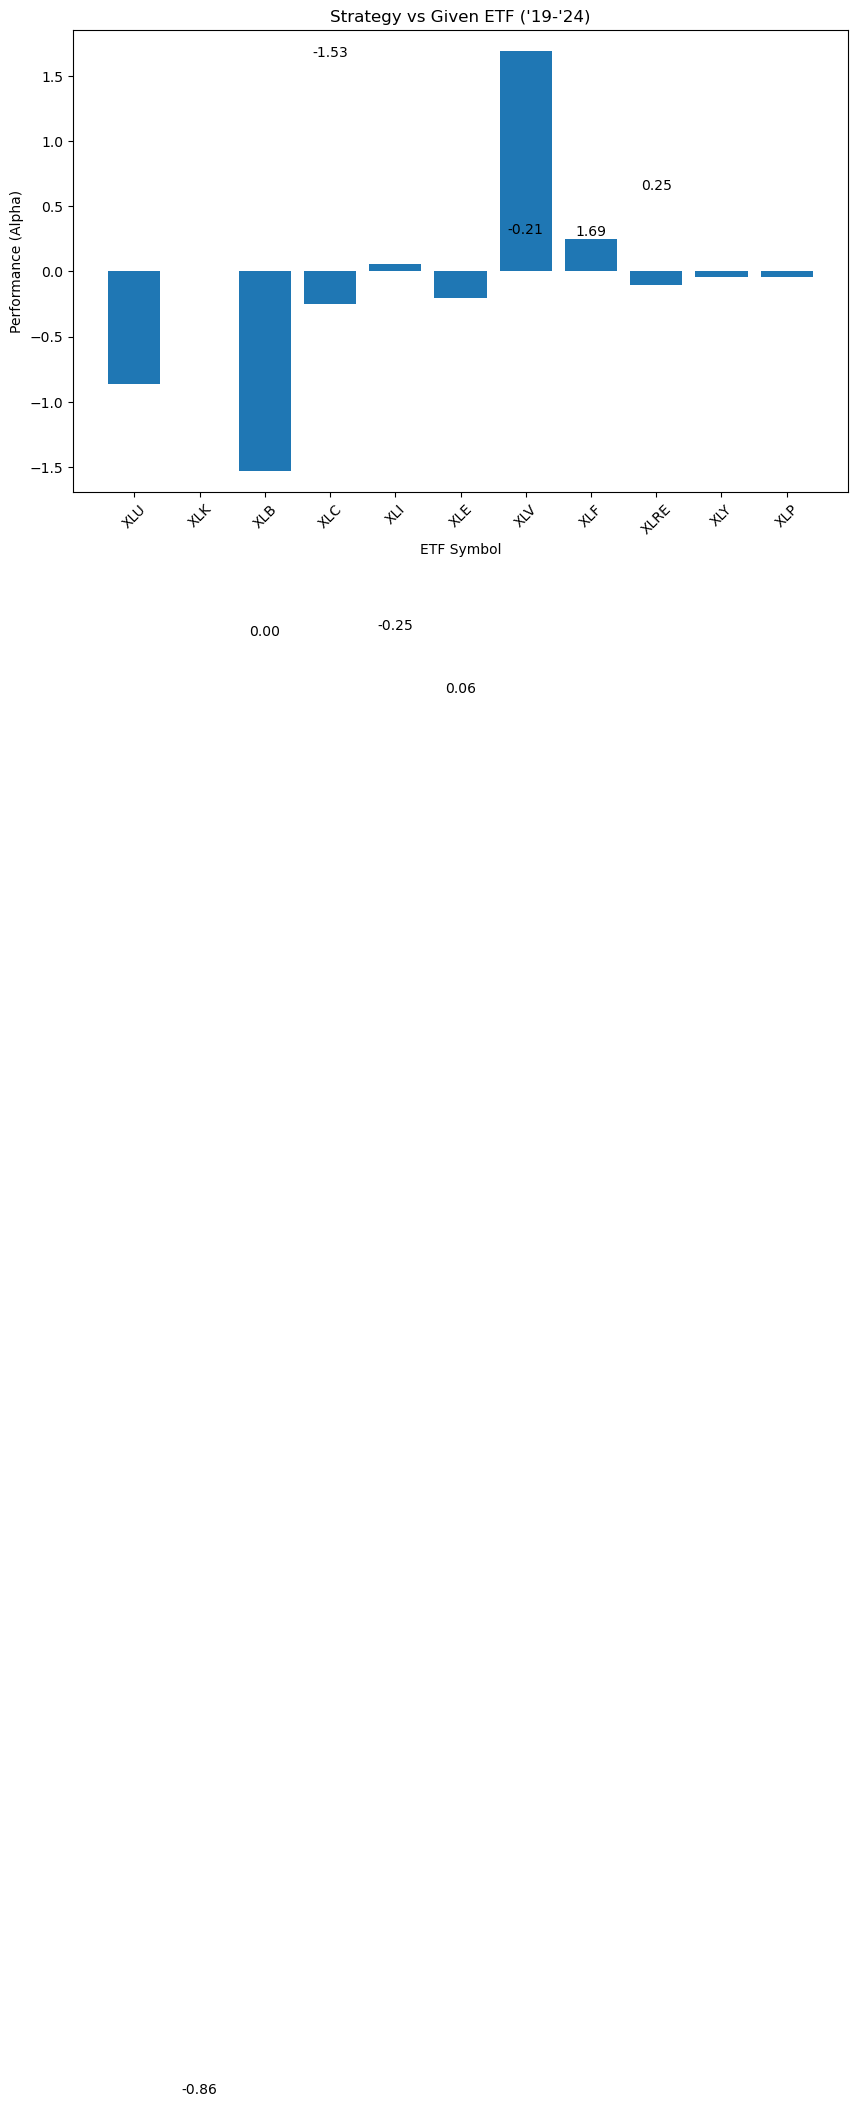

In [21]:
import matplotlib.pyplot as plt

# Define the dictionary
data = {'XLY': -0.04188163485551863,
        'XLRE': -0.10188650561674585,
        'XLU': -0.8645125299871198,
        'XLF': 0.2519229650162758,
        'XLI': 0.05931336636956355,
        'XLP': -0.04617517348973918,
        'XLB': -1.531289540823735,
        'XLE': -0.20634553470982842,
        'XLC': -0.25340731594607,
        'XLV': 1.6925345865023784,
        'XLK': 0.004161965443638465}

# Extract keys (stock symbols) and values (performance) from the dictionary
stocks = list(alphas_mean.keys())
performance = list(alphas_mean.values())

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed 
plt.bar(stocks, performance)

# Add data labels above each bar
for bar, value in zip(bars, performance):
  yval = bar.get_height()  # Get the height of each bar
  plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{value:.2f}", ha='center', va='bottom')  # Adjust offset as needed


# Set chart labels and title
plt.xlabel("ETF Symbol")
plt.ylabel("Performance (Alpha)")
plt.title("Strategy vs Given ETF ('19-'24)")

# Rotate x-axis labels for better readability with many tick labels
plt.xticks(rotation=45)

# Show the chart
plt.tight_layout()
plt.show()

In [13]:
df_XLU = alphas['XLU']
df_XLU['Total'] = df_XLU.sum(axis=1)
df_XLU['Total']

Date
2020-02-27   -14.062709
2020-02-28    -2.865941
2020-03-03     1.578434
2021-11-30    -2.822757
2022-01-24    -3.307100
2023-09-27     0.214579
2023-09-28     0.205267
2023-10-02     0.555888
Name: Total, dtype: float64

In [14]:
df_XLU['Total']

Date
2020-02-27   -14.062709
2020-02-28    -2.865941
2020-03-03     1.578434
2021-11-30    -2.822757
2022-01-24    -3.307100
2023-09-27     0.214579
2023-09-28     0.205267
2023-10-02     0.555888
Name: Total, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


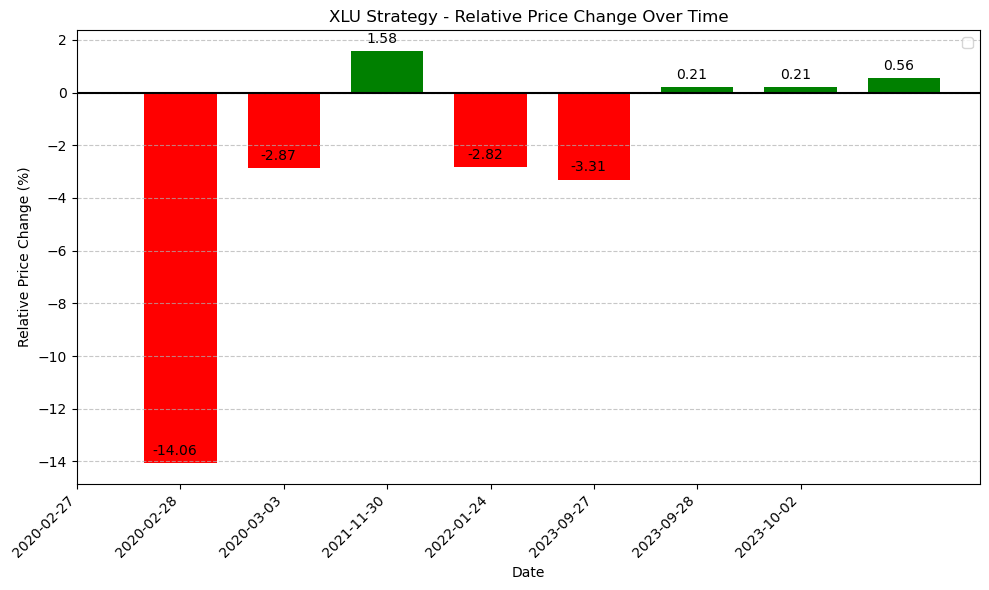

In [16]:
import matplotlib.pyplot as plt
from datetime import datetime

# Sample data (replace with your actual data)
dates = ["2020-02-27", "2020-02-28", "2020-03-03", "2021-11-30", "2022-01-24", "2023-09-27", "2023-09-28", "2023-10-02"]
prices = [-14.062729, -2.865940, 1.578434, -2.822768, -3.307098, 0.214579, 0.205266, 0.555888]

# Convert strings to datetime objects for plotting on the x-axis
date_objects = [datetime.strptime(date, "%Y-%m-%d") for date in dates]

# # Calculate the relative price change for each day (compared to the previous day)
# relative_changes = [prices[i] - prices[i - 1] for i in range(1, len(prices))]
# relative_changes.insert(0, 0)  # Add 0 for the first day (no previous day)

# Create the chart with red and green bars
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(prices)+1), prices, color=['green' if change > 0 else 'red' for change in prices], width=0.7)  # Adjust width as needed

# Annotate bars with relative change values (shifted slightly for better visibility)
for bar, change in zip(bars, prices):
    yval = bar.get_height()  # Get the bar height
    plt.text(bar.get_x() + 0.3, yval + 0.2, f"{change:.2f}", ha='center', va='bottom')  # Adjust offsets as needed

# Mark opening price with a horizontal line and label
plt.axhline(y=0, color='black', linestyle='-')

# Customize the chart
plt.xlabel('Date')
plt.ylabel('Relative Price Change (%)')  # Assuming percentages for relative changes
plt.title('XLU Strategy - Relative Price Change Over Time')
plt.xticks(range(len(dates)), [date.strftime("%Y-%m-%d") for date in date_objects], rotation=45, ha='right')  # Use formatted date strings for x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


#### Sample Graph

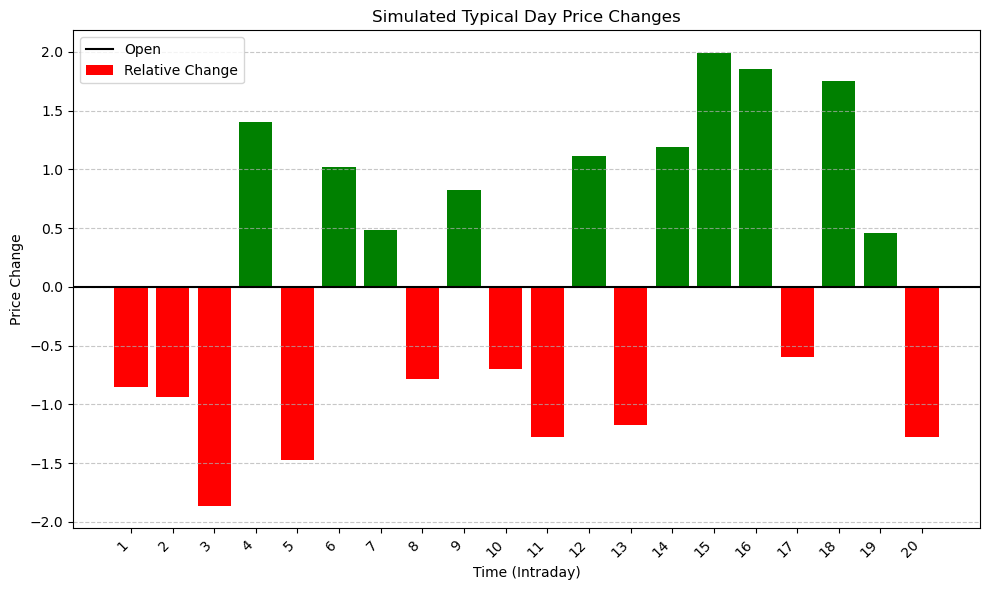

In [18]:
import matplotlib.pyplot as plt
import random

# Define opening price (replace with your data)
open_price = 100

# Random walk simulation (optional) to generate price changes within a range
# This is for illustrative purposes only and may not reflect actual price movements
num_points = 20
price_changes = [random.uniform(-2, 2) for _ in range(num_points)]  # Random changes within a range

# Calculate absolute prices based on the opening price and changes
prices = [open_price + sum(price_changes[:i]) for i in range(1, num_points + 1)]
prices.insert(0, open_price)  # Insert opening price at the beginning

# Calculate relative price changes for bars
relative_changes = [prices[i] - prices[i - 1] for i in range(1, len(prices))]

# Create a bar chart for relative changes
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(prices)), relative_changes, color=['green' if change > 0 else 'red' for change in relative_changes], label='Relative Change')  # Color bars based on change

# Mark opening price with a distinct marker and label
plt.axhline(y=0, color='black', linestyle='-', label='Open')

# Customize the chart
plt.xlabel('Time (Intraday)')
plt.ylabel('Price Change')  # Label y-axis for relative change
plt.title('Simulated Typical Day Price Changes')
plt.xticks(range(1, len(prices)), [f"{i}" for i in range(1, num_points + 1)], rotation=45, ha='right')  # Adjust x-tick labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()
